In [93]:
%%capture
!pip install torchmetrics photutils

In [94]:
!mkdir utils data data/gt data/nuc data/act 

In [95]:
%%capture

'''
Folder structure:
    lucyd.py
    evaluate.py
    train.py

    utils/
        ssim.py

    data/
        gt/
'''

In [96]:
TRAIN_DEPTH=32
BATCH_SIZE=16

In [124]:
from photutils.datasets import make_noise_image

In [140]:
import tifffile
import torch
import torch.nn.functional as F
import numpy as np 

def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    kernel = np.tensordot(kernel, gauss, axes=0)
    return kernel / np.sum(kernel)


def add_gaussian_noise(img, sigma):
    if sigma > 0:
        noise = np.random.normal(scale=sigma / 255., size=img.shape).astype(np.float32)
        noisy_img = (img + noise).astype(np.float32)
    else:
        noisy_img = img.astype(np.float32)
    
    return noisy_img

    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blur_levels = [1.,1.2,1.5]
noise_levels = [0,15,30]

# blur level, noise level, data object, D,H,W
blur_data = np.zeros((len(blur_levels),len(noise_levels),5,128,128,128))
gt_data = np.zeros((5,128,128,128))


for i in range(1,6):
    print('Starting to process object {}'.format(i))
    for blur_index, blur_level in enumerate(blur_levels):
        for noise_index, noise_level in enumerate(noise_levels):
            x = tifffile.imread('data/gt/'+str(i)+'.tif', maxworkers=6)
            x = (x - np.min(x))/(np.max(x) - np.min(x))

            k = gkern(l = 7, sig=blur_level)

            x_torch = torch.from_numpy(x).unsqueeze(0).unsqueeze(0).double().to(device)
            k_torch = torch.from_numpy(k).unsqueeze(0).unsqueeze(0).double().to(device)

            y_torch = F.conv3d(x_torch, k_torch, bias=None, stride=1, padding='same', dilation=1, groups=1)

            y = y_torch.cpu().detach().numpy() 
            y = ((y - np.min(y))/(np.max(y) - np.min(y)))

            y = add_gaussian_noise(y, noise_level)

            blur_data[blur_index,noise_index,i-1] = y
    gt_data[i-1] = x

Starting to process object 1
Starting to process object 2
Starting to process object 3
Starting to process object 4
Starting to process object 5


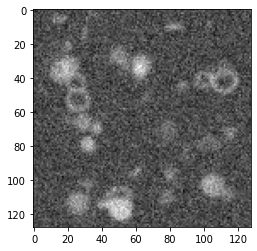

In [145]:
import matplotlib.pyplot as plt

plt.imshow(blur_data[0,2,0,80], cmap='gray')
plt.show()

In [146]:
print(blur_data.shape)
print(gt_data.shape)

(3, 3, 5, 128, 128, 128)
(5, 128, 128, 128)


In [147]:
import torch
from torch.utils import data
import numpy as np


class ImageLoader(data.Dataset):
    def __init__(self, gt, blur, depth, test=False):
        # depth: number of slices
        # gt and blur: arrays -> each "image" needs to split separately so there are no overlaps

        self.crop_depth = depth
        self.crop_size = 64
        self.im_size = gt.shape[-1]

        self.gt = gt
        self.blur = blur

        self.len = 128

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        im_index = np.random.randint(0, self.gt.shape[0])

        # blur level
        i0 = np.random.randint(0,blur_data.shape[0])
        # noise level
        i1 = np.random.randint(0,blur_data.shape[1])

        z_index = np.random.randint(0, self.im_size - self.crop_depth)
        x_index = np.random.randint(0, self.im_size - self.crop_size)
        y_index = np.random.randint(0, self.im_size - self.crop_size)

        blur = self.blur[i0,i1,im_index][z_index:(z_index+self.crop_depth),x_index:(x_index+self.crop_size),y_index:(y_index+self.crop_size)]
        gt = self.gt[im_index][z_index:(z_index+self.crop_depth),x_index:(x_index+self.crop_size),y_index:(y_index+self.crop_size)]

        blur = torch.unsqueeze(blur, dim=0)
        gt = torch.unsqueeze(gt, dim=0)

        return blur, gt

In [148]:
blur_data = torch.from_numpy(blur_data)
gt_data = torch.from_numpy(gt_data)

In [149]:
from torch.utils.data import DataLoader

blur_data_train = blur_data[:,:,:4]
gt_data_train = gt_data[:4]

blur_data_test = blur_data[:,:,4:]
gt_data_test = gt_data[4:]


train_loader = ImageLoader(gt_data_train, blur_data_train, depth=TRAIN_DEPTH)
train_dataloader = DataLoader(train_loader, batch_size=BATCH_SIZE, shuffle=True)

test_loader = ImageLoader(gt_data_test, blur_data_test, depth=TRAIN_DEPTH)
test_dataloader = DataLoader(test_loader, batch_size=BATCH_SIZE, shuffle=True)

In [150]:
from lucyd import LUCYD, device
from train import train

model_nuc = LUCYD(num_res=1).to(device)
print('number of parameters: {}'.format(sum(p.numel() for p in model_nuc.parameters())))

model_nuc = train(model_nuc, train_dataloader, test_dataloader)

number of parameters: 24964
 -- Staring training epoch 1 --
train loss: 0.6125800121426052
testing loss: 0.6929236596599814
testing ssim: 0.03347 +- 0.00208
testing psnr: 3.3113 +- 9.49637
 -- Staring training epoch 2 --
train loss: 0.3130975583990848
 -- Staring training epoch 3 --
train loss: 0.22108060356515172
 -- Staring training epoch 4 --
train loss: 0.1746448521113387
 -- Staring training epoch 5 --
train loss: 0.13771377013036767
 -- Staring training epoch 6 --
train loss: 0.10893969764064217
testing loss: 0.10912319610577045
testing ssim: 0.81536 +- 0.00652
testing psnr: 29.61692 +- 1.4984
 -- Staring training epoch 7 --
train loss: 0.10213931001377984
 -- Staring training epoch 8 --
train loss: 0.10273155866795756
 -- Staring training epoch 9 --
train loss: 0.08583903109053692
 -- Staring training epoch 10 --
train loss: 0.07534912673759506
 -- Staring training epoch 11 --
train loss: 0.0670522849795639
testing loss: 0.056503204965939094
testing ssim: 0.90153 +- 0.00395
test

In [ ]:
# ==============================================================================

In [162]:
blur.shape

torch.Size([1, 1, 32, 64, 64])

In [182]:
from utils.ssim import get_SSIM
from torchmetrics import PeakSignalNoiseRatio

blur_level_2 = 2. # [0.5, 2.]
noise_level_2 = 100 # [20,50,70,100]

# ////////////

k = gkern(l = 7, sig=blur_level_2)
k_torch = torch.from_numpy(k).unsqueeze(0).unsqueeze(0).double().to(device)

x = tifffile.imread('data/gt/5.tif', maxworkers=6)
x = (x - np.min(x))/(np.max(x) - np.min(x))

x_torch = torch.from_numpy(x).unsqueeze(0).unsqueeze(0).double().to(device)

y_torch = F.conv3d(x_torch, k_torch, bias=None, stride=1, padding='same', dilation=1, groups=1)

y = y_torch.cpu().detach().numpy()
y = ((y - np.min(y))/(np.max(y) - np.min(y)))

blur_data = add_gaussian_noise(y, noise_level_2)
blur_data = torch.from_numpy(blur_data).to(device)

# ////////////

im_size = 128
crop_depth = TRAIN_DEPTH
crop_size = 64

ssim_data = []
psnr_data = []

psnr = PeakSignalNoiseRatio().to(device)

model_nuc.eval()
with torch.no_grad():
    for _ in range(128):
        z_index = np.random.randint(0, im_size - crop_depth)
        x_index = np.random.randint(0, im_size - crop_size)
        y_index = np.random.randint(0, im_size - crop_size)

        blur = blur_data[:,:,z_index:(z_index+crop_depth),x_index:(x_index+crop_size),y_index:(y_index+crop_size)]
        gt = gt_data[-1][z_index:(z_index+crop_depth),x_index:(x_index+crop_size),y_index:(y_index+crop_size)]
        
        # blur = torch.unsqueeze(blur, dim=0)
        gt = torch.unsqueeze(gt, dim=0).unsqueeze(0).to(device)

        y, y_k, up = model_nuc(blur)

        ssim_val = get_SSIM(y, gt).detach().cpu()
        psnr_val = psnr(y, gt).detach().cpu()

        ssim_data.append(ssim_val)
        psnr_data.append(psnr_val)

print('testing ssim: {} +- {}'.format(np.round(np.mean(np.array(ssim_data)), 5), np.round(np.std(np.array(ssim_data)), 5)))
print('testing psnr: {} +- {}'.format(np.round(np.mean(np.array(psnr_data)), 5), np.round(np.std(np.array(psnr_data)), 5)))

testing ssim: 0.6311 +- 0.04533
testing psnr: 16.41986 +- 0.5763


In [ ]:
# ==============================================================================
'''
blur_level_2 = 0.5, noise_level_2 = 20
    testing ssim: 0.97247 +- 0.00349
    testing psnr: 26.85303 +- 0.77047

blur_level_2 = 0.5, noise_level_2 = 50
    testing ssim: 0.94629 +- 0.00633
    testing psnr: 24.35141 +- 0.75254

blur_level_2 = 0.5, noise_level_2 = 70
    testing ssim: 0.90398 +- 0.01204
    testing psnr: 21.78729 +- 0.69904

blur_level_2 = 0.5, noise_level_2 = 100
    testing ssim: 0.72326 +- 0.03881
    testing psnr: 17.46639 +- 0.54531


blur_level_2 = 2.0, noise_level_2 = 20
    testing ssim: 0.92716 +- 0.01082
    testing psnr: 23.48592 +- 0.76952

blur_level_2 = 2.0, noise_level_2 = 50
    testing ssim: 0.85751 +- 0.02215
    testing psnr: 20.99919 +- 0.79415

blur_level_2 = 2.0, noise_level_2 = 70
    testing ssim: 0.79946 +- 0.02871
    testing psnr: 19.38003 +- 0.62919

blur_level_2 = 2.0, noise_level_2 = 100
    testing ssim: 0.6311 +- 0.04533
    testing psnr: 16.41986 +- 0.5763
'''

In [188]:
torch.save(model_nuc.state_dict(), 'lucyd-mixture.pth')